In [1]:
using Plots, LaTeXStrings, TaylorSeries
include("AutomDiff_V2.jl")
import AD: Dual, xdual
#pyplot(grid=:false, size=(400,267))

In [2]:
"""
    ciclosestables!(xx, f, nit, nout, cc)

Esta función itera el mapeo `f`, de una variable, `nit+nout` veces, 
usando como condición inicial `x0=0`; los últimos `nout` iterados 
actualizan al vector `xx` que tiene longitud `nout`. `cc` es el valor
del parámetro del mapeo `f`. El mapeo `f` debe ser definido de 
tal manera que `f(x0,cc)` tenga sentido. La idea es los últimos 
`nout` iterados reflejen los ciclos estables del mapeo `f`. 
"""
function ciclosestables!(xx, f, nit, nout, cc,x0)
    @assert nit > 0 && nout > 0
    
    # Primeros nit iterados
   
    for it = 1:nit
        x0 = f(x0, cc)
    end
    
    # Se guardan los siguientes nout iterados
    for it = 1:nout
        x0 = f(x0, cc)
        @inbounds xx[it] = x0
    end
    
    nothing
end

ciclosestables!

In [3]:
"""
    diagbifurc(f, nit, nout, crange)

Itera el mapeo `f` `nit+nout` veces y regresa una matriz
cuya columna `i` tiene los últimos `nout` iterados del mapeo
para el valor del parámetro del mapeo `crange[i]`.

La función `f` debe ser definida de tal manera que `f(x0, c)` 
tenga sentido.
"""
function diagbifurc(f, nit, nout, crange,x0)
    xx = Vector{Float64}(nout)
    ff = Array{Float64,2}(nout, length(crange))
    
    for ic in eachindex(crange)
        c = crange[ic]
        ciclosestables!(xx, f, nit, nout, c,x0)
        ff[:,ic] = xx
    end
    
    return ff
end

diagbifurc

In [4]:
Ict(x,m, r,s) = (r*x^2)/((r-1)*x^2/m + x + s)

M=63
R=20
Ict1(x,s) = Ict(x,M,R,s)

crange = 0:1000

ff = diagbifurc(Ict1, 1000, 256, crange,50); 
cc = ones(size(ff)[1])*crange';

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
ff = reshape(ff, size(ff)[1]*size(ff)[2]);
cc = reshape(cc, size(ff));


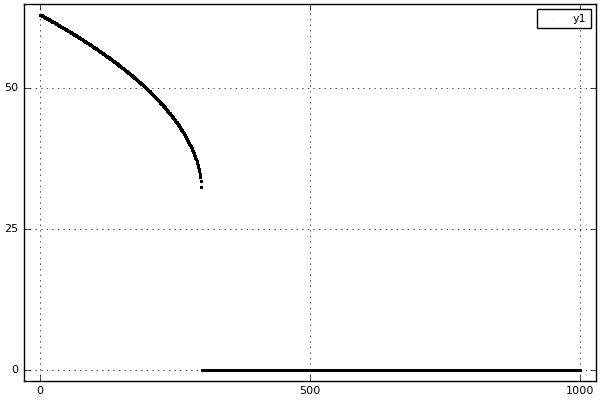

In [5]:
scatter(cc, ff, markersize= 0.05)


In [6]:
n = length(cc)
sc=Float64[]
for i in 1:n
    if ff[i]==0.0
        push!(sc,cc[i])
        
        break
    end
end
sc

/home/sof9409/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


1-element Array{Float64,1}:
 300.0

In [7]:
doc"""
    iterado(F,x0,n)

Dado un punto $x_0$, esta funció guarda a todas la iteraciones bajo $F$ en un arreglo.
"""

function iterado(F::Function,x0::Float64,n::Int)
    y = Float64[x0] ##El primer elemento es x_0
    x = x0
    for i in 1:n
        x=F(x) #El valor de x cambia con cada iteración
        push!(y,x) #Este nuevo valor se guarda en el arreglo
    end
    y
end

doc"""
    Lyapunov(y, F)

Dado un punto un arreglo que contenga todas las iteraciones bajo $F$ de $x_0$, calcula 
$\frac{1}{n} \sum_{i=1}^n \log\Big| \, f'(x_i)\, \Big|.$
"""

function Lyapunov(y, F::Function)
    n = length(y)
    l = 0
   
    for i in 1:n
        x = abs((F(xdual(y[i]))).der)
        l = l + log(x)
       
    end
    l/n
end

doc"""
mapeo_liap_all(crange::FloatRange, Qc::Function, x0::Float64, n = 100000)

Calcula el exponente de Lyapunov para un mapeo paramétrico $Q_c = Q_c(x, c)$ en un rango de parámetros `crange`, un
valor inicial `x0` y `n` iteraciones.
"""

function mapeo_liap_all(crange::FloatRange, Qc::Function, x0::Float64, n = 100000)
    mapeo = Float64[]
  
    for i in crange
        Qci(x) = Qc(x,i) 
        y = iterado(Qci,x0,n)
        l = Lyapunov(y, Qci)
        if abs(l)<Inf #En algunos puntos labda diverge, por lo que si tiende a infinito, se la asigna el valor-2.5
            push!(mapeo,l)      
        else
            push!(mapeo,0.0)       
        end
      
    end
    mapeo
end

mapeo_liap_all

In [8]:
crange = 0.0:1:500
mapeo= mapeo_liap_all(crange,Ict1,1000.0);


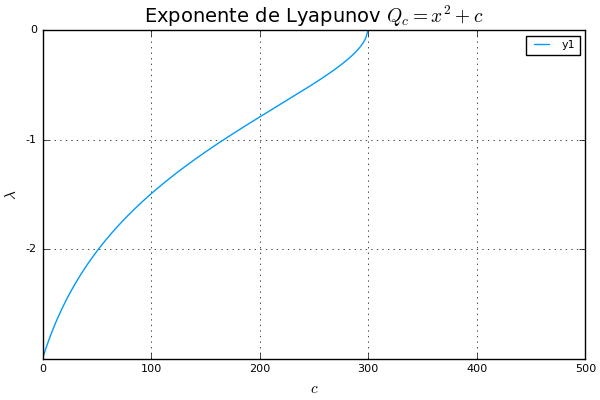

In [9]:
p = plot(crange,mapeo)

xlabel!(L"c")
ylabel!(L"\lambda")
title!(L"Exponente de Lyapunov $Q_c = x^2 +c$")

In [10]:
n = length(crange)
sc=Float64[]
for i in 1:n
    if mapeo[i]==0.0
        push!(sc,(crange[i-1]+crange[i])/2)
        
        break
    end
end
sc

1-element Array{Float64,1}:
 299.5

In [11]:
Ict(x,m, r,s) = (r*x^2)/((r-1)*x^2/m + x + s)

M=63
R=20
Ict1(x,s) = Ict(x,M,R,s)

crange = 0:1000

ff = diagbifurc(Ict1, 1000, 256, crange,50); 
cc = ones(size(ff)[1])*crange';

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
ff = reshape(ff, size(ff)[1]*size(ff)[2]);
cc = reshape(cc, size(ff));

n = length(cc)
sc=Float64[]
for i in 1:n
    if ff[i]==0.0
        push!(sc,cc[i])
        break
    end
end
sc

1-element Array{Float64,1}:
 300.0

In [12]:
function SC(Mrange,Rrange)
    R = length(Rrange)
    Mmax = length(Mrange)
    M = zeros(Mmax,R)
    crange = 0:1000
    for i in 1:Mmax
        for j in 1:R
            I(x,s) = Ict(x,Mrange[i],Rrange[j],s)
            
            ff = diagbifurc(I, 1000, 256, crange,100); 
            cc = ones(size(ff)[1])*crange';
            
            if mod(j,10) == 0
                @show(j,i)
            end
            
            n = length(cc)
            for k in 1:n
                if ff[k]==0.0
                    M[i,j]= cc[k]
                    break
                end
            end
        end
    end
    M
end
            

SC (generic function with 1 method)

In [36]:
Rrange = 4.5:1/2^5:5
M=SC(1:100,Rrange)

j = 10
i = 1
j = 10
i = 2
j = 10
i = 3
j = 10
i = 4
j = 10
i = 5
j = 10
i = 6
j = 10
i = 7
j = 10
i = 8
j = 10
i = 9
j = 10
i = 10
j = 10
i = 11
j = 10
i = 12
j = 10
i = 13
j = 10
i = 14
j = 10
i = 15
j = 10
i = 16
j = 10
i = 17
j = 10
i = 18
j = 10
i = 19
j = 10
i = 20
j = 10
i = 21
j = 10
i = 22
j = 10
i = 23
j = 10
i = 24
j = 10
i = 25
j = 10
i = 26
j = 10
i = 27
j = 10
i = 28
j = 10
i = 29
j = 10
i = 30
j = 10
i = 31
j = 10
i = 32
j = 10
i = 33
j = 10
i = 34
j = 10
i = 35
j = 10
i = 36
j = 10
i = 37
j = 10
i = 38
j = 10
i = 39
j = 10
i = 40
j = 10
i = 41
j = 10
i = 42
j = 10
i = 43
j = 10
i = 44
j = 10
i = 45
j = 10
i = 46
j = 10
i = 47
j = 10
i = 48
j = 10
i = 49
j = 10
i = 50
j = 10
i = 51
j = 10
i = 52
j = 10
i = 53
j = 10
i = 54
j = 10
i = 55
j = 10
i = 56
j = 10
i = 57
j = 10
i = 58
j = 10
i = 59
j = 10
i = 60
j = 10
i = 61
j = 10
i = 62
j = 10
i = 63
j = 10
i = 64
j = 10
i = 65
j = 10
i = 66
j = 10
i = 67
j = 10
i = 68
j = 10
i = 69
j = 10
i = 70
j = 10
i = 71
j = 10
i = 72
j

100×17 Array{Float64,2}:
  1.0   1.0   1.0   1.0   1.0   1.0   1.0  …   1.0   1.0   1.0    1.0    2.0
  2.0   2.0   2.0   2.0   2.0   2.0   2.0      2.0   2.0   2.0    2.0    3.0
  3.0   3.0   3.0   3.0   3.0   3.0   3.0      3.0   3.0   3.0    3.0    4.0
  4.0   4.0   4.0   4.0   4.0   4.0   4.0      4.0   4.0   4.0    4.0    5.0
  5.0   5.0   5.0   5.0   5.0   5.0   5.0      5.0   5.0   5.0    5.0    6.0
  6.0   6.0   6.0   6.0   6.0   6.0   6.0  …   6.0   6.0   6.0    6.0    7.0
  7.0   7.0   7.0   7.0   7.0   7.0   7.0      7.0   7.0   7.0    7.0    8.0
  8.0   8.0   8.0   8.0   8.0   8.0   8.0      8.0   8.0   8.0    8.0    9.0
  8.0   8.0   9.0   9.0   9.0   9.0   9.0      9.0   9.0   9.0    9.0   10.0
  9.0   9.0   9.0   9.0  10.0  10.0  10.0     10.0  10.0  10.0   10.0   11.0
 10.0  10.0  10.0  10.0  10.0  11.0  11.0  …  11.0  11.0  11.0   11.0   12.0
 11.0  11.0  11.0  11.0  11.0  11.0  12.0     12.0  12.0  12.0   12.0   13.0
 12.0  12.0  12.0  12.0  12.0  12.0  12.0     13.0 


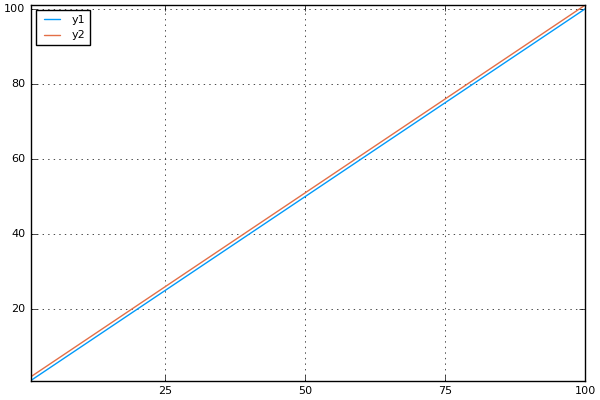

In [45]:
plot(M[:,end-1:end])

In [115]:
Rrange = 5:40
M1=SC(1:50,Rrange)

j = 10
i = 1
j = 20
i = 1
j = 30
i = 1
j = 10
i = 2
j = 20
i = 2
j = 30
i = 2
j = 10
i = 3
j = 20
i = 3
j = 30
i = 3
j = 10
i = 4
j = 20
i = 4
j = 30
i = 4
j = 10
i = 5
j = 20
i = 5
j = 30
i = 5
j = 10
i = 6
j = 20
i = 6
j = 30
i = 6
j = 10
i = 7
j = 20
i = 7
j = 30
i = 7
j = 10
i = 8
j = 20
i = 8
j = 30
i = 8
j = 10
i = 9
j = 20
i = 9
j = 30
i = 9
j = 10
i = 10
j = 20
i = 10
j = 30
i = 10
j = 10
i = 11
j = 20
i = 11
j = 30
i = 11
j = 10
i = 12
j = 20
i = 12
j = 30
i = 12
j = 10
i = 13
j = 20
i = 13
j = 30
i = 13
j = 10
i = 14
j = 20
i = 14
j = 30
i = 14
j = 10
i = 15
j = 20
i = 15
j = 30
i = 15
j = 10
i = 16
j = 20
i = 16
j = 30
i = 16
j = 10
i = 17
j = 20
i = 17
j = 30
i = 17
j = 10
i = 18
j = 20
i = 18
j = 30
i = 18
j = 10
i = 19
j = 20
i = 19
j = 30
i = 19
j = 10
i = 20
j = 20
i = 20
j = 30
i = 20
j = 10
i = 21
j = 20
i = 21
j = 30
i = 21
j = 10
i = 22
j = 20
i = 22
j = 30
i = 22
j = 10
i = 23
j = 20
i = 23
j = 30
i = 23
j = 10
i = 24
j = 20
i = 24
j = 30
i = 24
j = 10
i = 25
j = 2

50×36 Array{Float64,2}:
  2.0   2.0   2.0   2.0    3.0    3.0  …    9.0   10.0   10.0   10.0   10.0
  3.0   3.0   4.0   4.0    5.0    5.0      18.0   19.0   19.0   20.0   20.0
  4.0   4.0   5.0   6.0    7.0    7.0      27.0   28.0   28.0   29.0   30.0
  5.0   6.0   7.0   8.0    9.0   10.0      36.0   37.0   38.0   39.0   40.0
  6.0   7.0   8.0   9.0   11.0   12.0      44.0   46.0   47.0   48.0   49.0
  7.0   8.0  10.0  11.0   13.0   14.0  …   53.0   55.0   56.0   58.0   59.0
  8.0   9.0  11.0  13.0   15.0   16.0      62.0   64.0   65.0   67.0   69.0
  9.0  11.0  13.0  15.0   17.0   19.0      71.0   73.0   75.0   77.0   79.0
 10.0  12.0  14.0  16.0   19.0   21.0      79.0   82.0   84.0   86.0   88.0
 11.0  13.0  16.0  18.0   21.0   23.0      88.0   91.0   93.0   96.0   98.0
 12.0  14.0  17.0  20.0   23.0   25.0  …   97.0  100.0  102.0  105.0  108.0
 13.0  16.0  19.0  22.0   25.0   28.0     106.0  109.0  112.0  115.0  118.0
 14.0  17.0  20.0  23.0   27.0   30.0     114.0  118.0  121.0  1


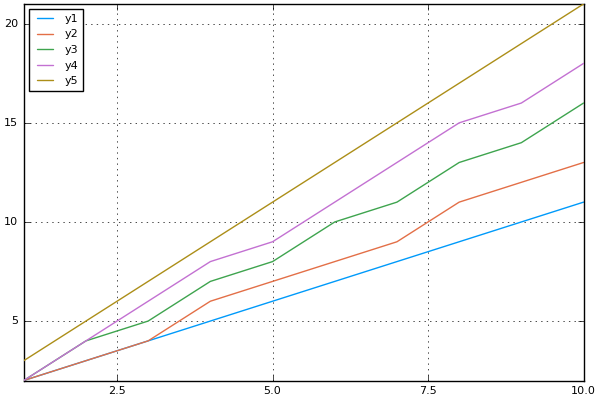

In [116]:
plot(M1[1:10,1:5])

In [117]:
writecsv("M1.csv", M1)


In [118]:
MS = readcsv("M1.csv")

50×36 Array{Float64,2}:
  2.0   2.0   2.0   2.0    3.0    3.0  …    9.0   10.0   10.0   10.0   10.0
  3.0   3.0   4.0   4.0    5.0    5.0      18.0   19.0   19.0   20.0   20.0
  4.0   4.0   5.0   6.0    7.0    7.0      27.0   28.0   28.0   29.0   30.0
  5.0   6.0   7.0   8.0    9.0   10.0      36.0   37.0   38.0   39.0   40.0
  6.0   7.0   8.0   9.0   11.0   12.0      44.0   46.0   47.0   48.0   49.0
  7.0   8.0  10.0  11.0   13.0   14.0  …   53.0   55.0   56.0   58.0   59.0
  8.0   9.0  11.0  13.0   15.0   16.0      62.0   64.0   65.0   67.0   69.0
  9.0  11.0  13.0  15.0   17.0   19.0      71.0   73.0   75.0   77.0   79.0
 10.0  12.0  14.0  16.0   19.0   21.0      79.0   82.0   84.0   86.0   88.0
 11.0  13.0  16.0  18.0   21.0   23.0      88.0   91.0   93.0   96.0   98.0
 12.0  14.0  17.0  20.0   23.0   25.0  …   97.0  100.0  102.0  105.0  108.0
 13.0  16.0  19.0  22.0   25.0   28.0     106.0  109.0  112.0  115.0  118.0
 14.0  17.0  20.0  23.0   27.0   30.0     114.0  118.0  121.0  1

In [140]:
dif=MS
    for j in 1:length(M1[:,1])-1 #fixed m
        dif[j,:]= M1[j+1,:]-M1[j,:]
end

dif
dif[end,:]= dif[end-1,:]
steadyR = Float64[]
steapR = Float64[]
for i in 1:36
    u = unique(dif[:,i])
    if length(u)==1
        push!(steadyR,Rrange[i])
        push!(steapR,u[1])
    end
end
steadyR,steapR

([5.0,9.0,13.0,17.0,21.0,25.0,29.0,33.0,37.0],[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0])

In [ ]:
dif2=MS
    for j in 1:length(M1[1,:])-1 #fixed m
        dif2[:,j]=  M1[:,j+1]-M1[:,j]
end

dif2
dif[:,end]= dif[:,end-1]
steadyM = Float64[]
steapM = Float64[]
for i in 1:50
    u = unique(dif[i,:])
    if length(unique(dif[i,:]))==1
        push!(steadyM,i)
        push!(steapM,u[1])
    end
end
steadyM,steapM

([4.0,8.0,12.0,16.0,20.0,24.0,28.0,32.0,36.0,40.0,44.0,48.0],[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0])

In [126]:
unique(dif[:,1])

LoadError: LoadError: MethodError: Cannot `convert` an object of type Int64 to an object of type Range{T}
This may have arisen from a call to the constructor Range{T}(...),
since type constructors fall back to convert methods.
while loading In[126], in expression starting on line 1


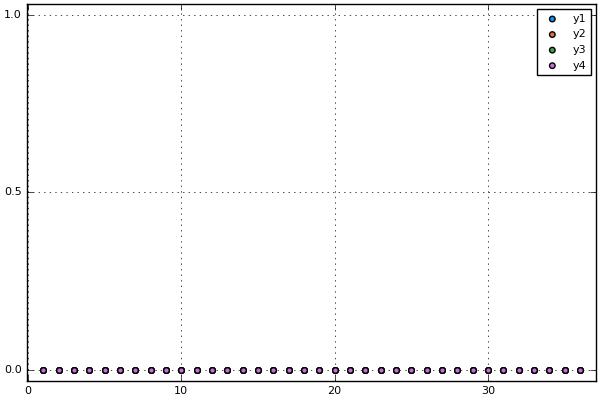

In [99]:
scatter(M1[1,:])
scatter!(M1[2,:])
scatter!(M1[3,:])
scatter!(M1[4,:])

In [18]:
Rrange = 1+1/2^2:2:16
M2=SC(15,Rrange)

1×8 Array{Float64,2}:
 1.0  9.0  16.0  24.0  31.0  39.0  46.0  54.0

In [61]:
unique([1,1,2,3])

3-element Array{Int64,1}:
 1
 2
 3